In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
from scipy.stats import pearsonr, linregress

In [3]:
# -------------------------
#  Load CSV data
# -------------------------
df = pd.read_csv("mtcars_manipulated.csv")  # From Tuvshin manipulated data
mpg = df['mpg'].dropna().values 
hp = df['hp'].dropna().values

original_df = pd.read_csv("mtcars_original.csv")
original_mpg = original_df['mpg']
original_hp = original_df['hp']

In [64]:
# Benford expected distribution
def benford_distribution():
    return np.array([np.log10(1 + 1/d) for d in range(1, 10)])

# Extract first digit from numeric array
def extract_first_digit(array):
    first_digits = []
    for val in array:
        val_str = str(abs(val)).replace('.', '')
        if val_str and val_str[0].isdigit():
            first_digits.append(int(val_str[0]))
    return first_digits

# === Extract first digit from numeric array ===
def extract_first_digits(data):
    data = pd.Series(data).dropna()
    first_digits = data.astype(str).str.replace('.', '', regex=False).str.strip().str[0]
    return first_digits.astype(int)

# === Calculate Benford statistics: Chi-square, p-value, Euclidean Distance ===
def benford_stats(data):
    first_digits = extract_first_digits(data)
    observed_counts = first_digits.value_counts().sort_index()
    observed = observed_counts.reindex(range(1, 10), fill_value=0).values
    expected = benford_distribution() * observed.sum()

    chi2, pval = chisquare(f_obs=observed, f_exp=expected)
    euclidean_dist = np.linalg.norm(observed / observed.sum() - benford_distribution())

    return chi2, pval, euclidean_dist

def synthesize_benford_mpg(n_samples=1000, min_val=15, max_val=40, noise_std=0.1, seed=2):
    np.random.seed(seed)  # Set the seed for reproducibility
    samples = []
    while len(samples) < n_samples:
        digit = np.random.choice(benford_digits, p=benford_probs)
        exponent = np.random.uniform(1.3, 1.5)  # Control scale
        noise = np.random.normal(0, noise_std)
        value = digit * 10 ** exponent + noise
        if min_val <= value <= max_val:
            samples.append(value)
    return np.array(samples[:n_samples]) 

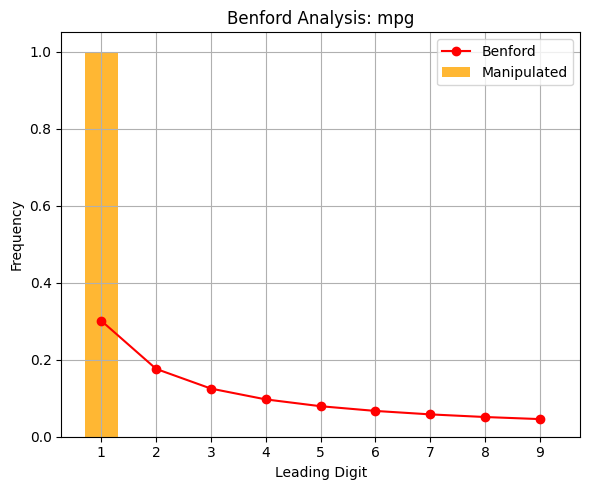

=== Benford's Law Evaluation for manipulated mpg ===
Chi-Square       : 74.30
p-value          : 0.000000000000681
Euclidean Distance: 0.7506


In [75]:
# Get observed frequencies
first_digits = extract_first_digit(mpg)
observed_counts = pd.Series(first_digits).value_counts().sort_index()
observed_freq = observed_counts.reindex(range(1, 10), fill_value=0) / len(first_digits)

# Calculate stats
chi2, pval, eu_dist = benford_stats(mpg)

# Plot Benford vs Observed
plt.figure(figsize=(6, 5))
plt.bar(observed_freq.index, observed_freq.values, width=0.6, color='orange', alpha=0.8, label='Manipulated')
plt.plot(range(1, 10), benford_distribution(), 'ro-', label="Benford")
plt.xlabel("Leading Digit")
plt.ylabel("Frequency")
plt.title("Benford Analysis: mpg")
plt.xticks(range(1, 10))
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Print results
print("=== Benford's Law Evaluation for manipulated mpg ===")
print(f"Chi-Square       : {chi2:.2f}")
print(f"p-value          : {pval:.15f}")
print(f"Euclidean Distance: {eu_dist:.4f}")

In [68]:
# --- Benford distribution ---
benford_probs = np.array([np.log10(1 + 1/d) for d in range(1, 10)])
benford_digits = np.arange(1, 10)


# Reconstructed
synthesized_mpg = synthesize_benford_mpg(n_samples=len(hp))

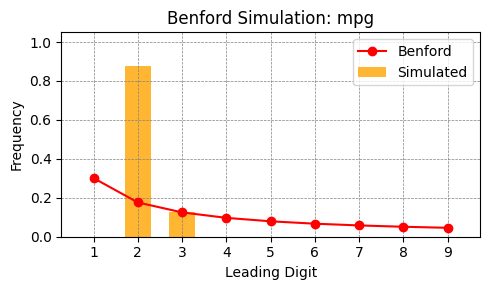

In [85]:
# Get observed frequencies
first_digits = extract_first_digit(synthesized_mpg)
observed_counts = pd.Series(first_digits).value_counts().sort_index()
observed_freq = observed_counts.reindex(range(1, 10), fill_value=0) / len(first_digits)

# Calculate stats
chi2S, pvalS, eu_distS = benford_stats(synthesized_mpg)

# Plot Benford vs Observed
plt.figure(figsize=(5, 3))
plt.bar(observed_freq.index, observed_freq.values, width=0.6, color='orange', alpha=0.8, label='Simulated')
plt.plot(range(1, 10), benford_distribution(), 'ro-', label="Benford")
plt.xlabel("Leading Digit")
plt.ylabel("Frequency")
plt.title("Benford Simulation: mpg")
plt.xticks(range(1, 10))
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()



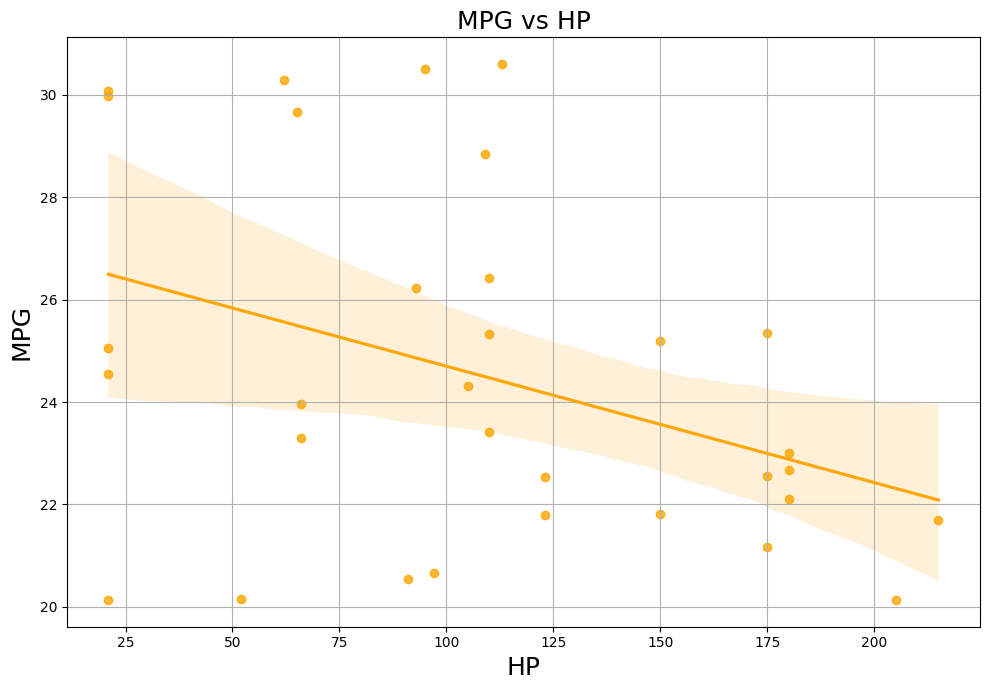

In [98]:
# --- Correlation ---
corr, pval = pearsonr(hp, synthesized_mpg)

# -------------------------
#  Scatter Plot
# -------------------------
plt.figure(figsize=(10, 7))

sns.regplot(x=hp, y=synthesized_mpg, scatter_kws={'color': 'orange'}, line_kws={'color': 'orange'})
plt.title(f"MPG vs HP", fontsize=18) #\nr = {corr:.2f}, p = {pval:.4f}", fontsize=18)
plt.xlabel("HP", fontsize=18)
plt.ylabel("MPG", fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()


Correlation direction reversed due to data manipulation.


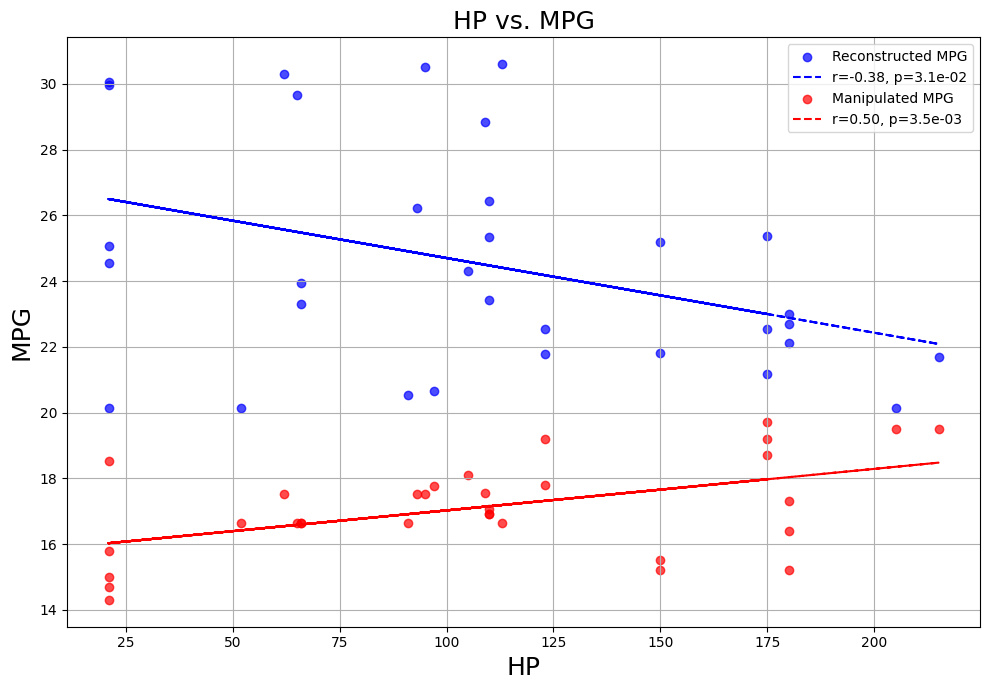

In [95]:
# -----------------------------
# Correlations
# -----------------------------
r1, p1 = pearsonr(hp, mpg) # From Tuvshin manipulated data
r2, p2 = pearsonr(hp, synthesized_mpg)# From Beford manipulated data

# -----------------------------
# Print correlation direction change
# -----------------------------
if r1 * r2 < 0:
    print("Correlation direction reversed due to data manipulation.")
else:
    print("No reversal in correlation direction detected.")

# Fit lines
slope1, intercept1, *_ = linregress(hp, mpg)
slope2, intercept2, *_ = linregress(hp, synthesized_mpg)
line1 = slope1 * hp + intercept1
line2 = slope2 * hp + intercept2

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 7))
plt.scatter(hp, synthesized_mpg, color='blue', label='Reconstructed MPG', alpha=0.7)
plt.plot(hp, line2, 'b--', label=f'r={r2:.2f}, p={p2:.1e}')

plt.scatter(hp, mpg, color='red', label='Manipulated MPG', alpha=0.7)
plt.plot(hp, line1, 'r--', label=f'r={r1:.2f}, p={p1:.1e}')


plt.xlabel("HP", fontsize=18)
plt.ylabel("MPG", fontsize=18)
plt.title("HP vs. MPG", fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

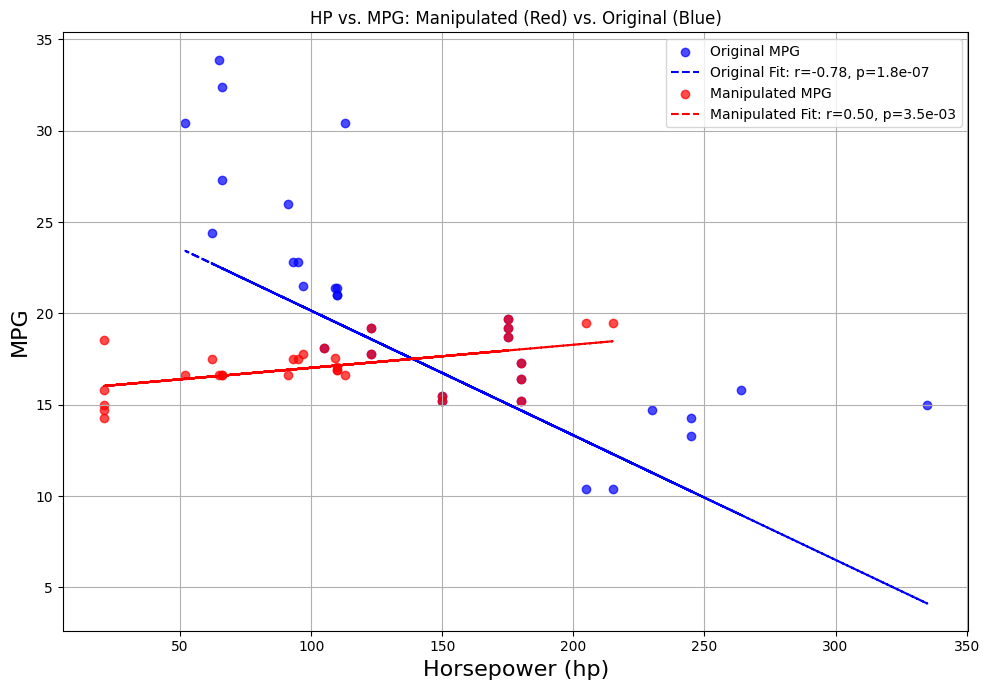

In [73]:
# -----------------------------
# Correlations
# -----------------------------
r3, p3 = pearsonr(hp, mpg)
r4, p4 = pearsonr(original_hp, original_mpg)

# Fit lines
slope3, intercept3, *_ = linregress(hp, mpg)
slope4, intercept4, *_ = linregress(original_hp, original_mpg)
line3 = slope3 * hp + intercept3
line4 = slope4 * original_hp + intercept2

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 7))

plt.scatter(original_hp, original_mpg, color='blue', label='Original MPG', alpha=0.7)
plt.plot(original_hp, line4, 'b--', label=f'Original Fit: r={r4:.2f}, p={p4:.1e}')

plt.scatter(hp, mpg, color='red', label='Manipulated MPG', alpha=0.7)
plt.plot(hp, line3, 'r--', label=f'Manipulated Fit: r={r3:.2f}, p={p3:.1e}')

plt.xlabel("Horsepower (hp)", fontsize=18)
plt.ylabel("MPG", fontsize=18)
plt.title("HP vs. MPG: Manipulated (Red) vs. Original (Blue)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### 

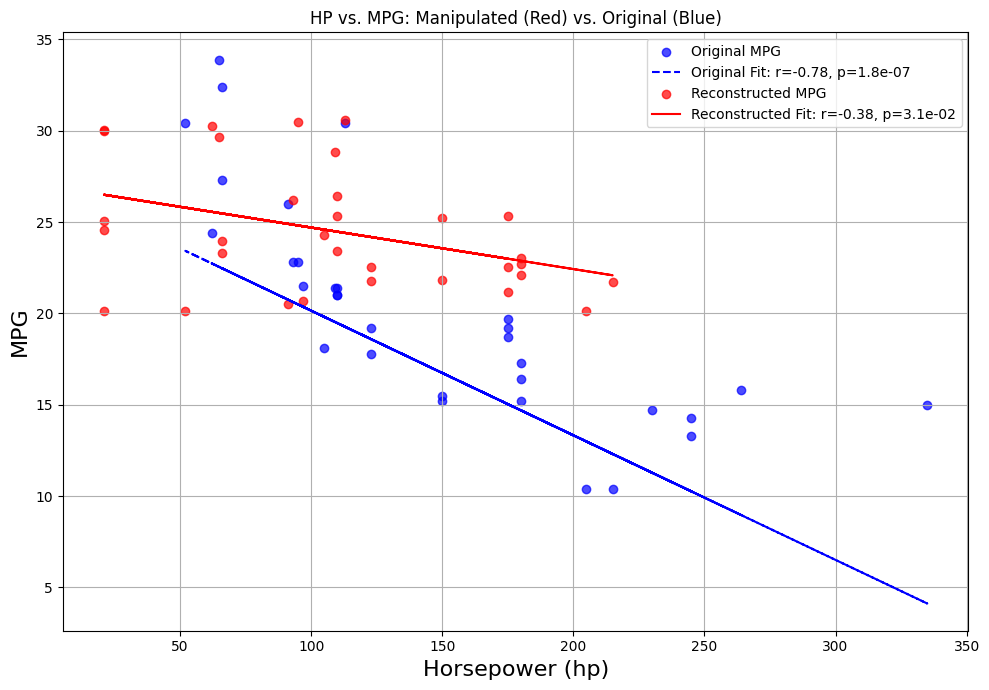

In [10]:
# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 7))

plt.scatter(original_hp, original_mpg, color='blue', label='Original MPG', alpha=0.7)
plt.plot(original_hp, line4, 'b--', label=f'Original Fit: r={r4:.2f}, p={p4:.1e}')


plt.scatter(hp, synthesized_mpg, color='red', label='Reconstructed MPG', alpha=0.7)
plt.plot(hp, line2, 'red', label=f'Reconstructed Fit: r={r2:.2f}, p={p2:.1e}')



plt.xlabel("Horsepower (hp)", fontsize=16)
plt.ylabel("MPG", fontsize=16)
plt.title("HP vs. MPG: Manipulated (Red) vs. Original (Blue)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()